# Variational Autoencoder

Before starting to code, let's review the theory behind Variational Autoencoders (VAEs). 
The goal of VAEs is to learn the underlying probability distribution of the data it is trained on - i.e., to model the latent space of the data. The latent space should capture the essence of the data in a more compact way. But with what kind of (prior) distribution over the latent space, $p(z)$, should we start?

<br />

### Choice of the latent distribution prior $p(z)$
As we want it to be continuous for later sampling, the simplest possible prior is a standard normal distribution: $p(z)=\mathcal{N}(z|0,\mathcal{I})$

However, it is unlikely that this prior captures the characteristics of the observed data (e.g., the images that we plan to put into the VAE). How can we tailor the latent distribution to the specifics of the given data - or differently, how can we learn $p(z|x)$? 

<br />

### Variational Inference (deriving the ELBO)
To answer this, let's make a quick excursion to Variational Inference (VI). VI is a machine learning method that aims to approximate a probability distribution through optimization. This opens the question how we can optimize a distribution to capture the characteristics of the input data. To answer this, let's start with Bayes Formula:

$p(z|x) = \frac{p(x|z)p(z)}{p(x)}$

The problem here is that $p(x)$ is intractable as it involves the integral over all possible values of the latent variable, z, which is usually high-dimensional: $p(x) = \int p(x, z) \, dz$

This means we cannot just get the posterior distribution $p(z|x)$. But, we can approximate it with an easier-to-work with surrogate distribution that we will call $q(z)$. As a metric to see how close this surrogate matches $p(z|x)$, we may use the KL Divergence. The KL Divergence is a measure of how similar (or distant) two distributions are. 

$\text{KL}(q(z) || p(z|x)) = \int q(z) \log\left(\frac{q(z)}{p(z|x)}\right) \, dz$

Since we don't have $p(z|x)$, let's rewrite it:

$p(z|x)=\frac{p(x|z)p(z)}{p(x)}=\frac{p(x,z)}{p(x)}$

So, we can replace $p(z|x)$ in the upper equation:

$\text{KL}(q(z) || \frac{p(x,z)}{p(x)}) = \int q(z) \log\left(\frac{q(z)p(x)}{p(x,z)}\right) \, dz$

Additionally, we can change the numerator and denominator in the log expression, by putting a minus in front of the equation (which equalizes $log()^{-1}$):

$\text{KL}(q(z) || \frac{p(x,z)}{p(x)}) =-\int q(z) \log\left(\frac{p(x,z)}{q(z)p(x)}\right) \, dz$

Then, let's put $p(x)$ (which we don't have) into a separate log:

$\text{KL}(q(z) || \frac{p(x,z)}{p(x)}) =-\int q(z) \log\left(\frac{p(x,z)}{q(z)}\right) \, dz + \int q(z) \log{p(x)}\, dz$

The expectation over something that does not contain z equals what the expectation was taken over, i.e.: $\int q(z) \log{p(x)}\, dz = \mathbb{E}_{q(z)}[\log p(x|z)]= \log{p(x)}$

So, we have:

$\text{KL}(q(z) || \frac{p(x,z)}{p(x)}) =-\int q(z) \log\left(\frac{p(x,z)}{q(z)}\right) \, dz + \log{p(x)}$

It may look like we just shifted things around, but notice a few things:

1. A probability, like $p(x)$, ranges between 0 and 1. The log of something between 0 and 1 will always be negative or 0. I.e.: $\log{p(x)}\leq0$
2. We don't have $p(x)$, but we know that it is fixed because we observe the dataset and  the probability does not change depending on what surrogate posterior we choose.
3. The KL Divergence is always positive or 0: $\text{KL}(q(z) || \frac{p(x,z)}{p(x)})\geq0$

Therefore, we can deduce (important!): $\int q(z) \log\left(\frac{p(x,z)}{q(z)}\right) \, dz$ has to be more negative than $\log{p(x)}$, otherwise the KL divergence cannot be positive. That means, $\int q(z) \log\left(\frac{p(x,z)}{q(z)}\right) \, dz$ bounds $\log{p(x)}$. Since $\log{p(x)}$ is called the "evidence", we call $\mathcal{L} = \int q(z) \log\left(\frac{p(x,z)}{q(z)}\right) \, dz$, frequently expressed as $\mathcal{L} = \mathbb{E}_{z \sim q(z)}[\log\left (\frac{p(x,z)}{q(z)}\right)]$, the **Evidence Lower Bound (ELBO)**.

Thus, we have something that is computable and that we can optimize to be close to the posterior we always wanted! We need to find the parameters and the distribution $q(z)$ that maximize the ELBO.

<br />

### Learning the parameters of $q(z)$

We have the ELBO now, which enables us to optimize the parameters of $q(z)$. Let's call the parameters $\phi$. Thus, for one input sample, $x^{(i)}$, we could learn the optimal $\phi$.

$\phi^{(i)}_{optimal}=\underset{\phi^{(i)}}{\mathrm{argmax}}\:\mathcal{L}_{i}(\phi^{(i)})$

However, for many samples we would have to learn separate parameters for each sample (since we have a distribution $q(z)$ for each sample!) and how would we obtain the latent features for a new sample? Instead, we may train a neural network, $f_{\lambda}$, mapping every sample in our dataset to the optimal parameters $\phi^{(i)}_{optimal}$. In fact, this neural network is going to be the **Encoder** of our VAE!

$\underset{\lambda}{\mathrm{argmax}}\:\frac {1}{N}\sum_{i=1}^{N}\mathcal{L}_{i}(f_{\lambda}(x^{(i)}))$

Long story short - this is what we want to optimize in the Encoder part. Let's look at the Decoder, now.

<br />

### Choosing the output distribution $p(x|z)$
For every z, we want to have a probability distribution over x that maximizes the likelihood of getting back our input.
Let's assume a gaussian distribution again: $p(x|z)=\mathcal{N}(x|\mu,\mathcal{I})$, parameterized by $\theta$.

Similar to $q(z)$, we want to learn the parameters with a neural network, $g_{\gamma}$, which is going to be our **Decoder**. Thus, $\mu = g_{\gamma}(z)$. 
While $p(x|z)$ is "just a gaussian", g models the mean of this gaussian and can introduce complex transformations on the initial distribution.

Let's write out the final loss which we will try to optimize with regards to the parameters of the Encoder and Decoder.

<br />

### VAE Loss Function
This was the ELBO equation we derived: $\mathcal{L} = \mathbb{E}_{z \sim q(z)}[\log\left (\frac{p(x,z)}{q(z)}\right)]$

To get an even better intuition what we are doing, let's rewrite it a little for the last time:

$\mathcal{L}(\phi, \theta) = \mathbb{E}_{z \sim q(z)}[\log (p_{\theta}(x|z)) + \log(p(z)) - \log(q_{\phi}(z))] \\ \:\:\:\:\:\:\:\:\:\:\:\:\:\:\:= \mathbb{E}_{z \sim q(z)}[\log (p_{\theta}(x|z))] - KL(q_{\phi}(z) || p(z))$

From this expression, think about what maximizing $\mathcal{L}(\phi, \theta)$ means:

1. Maximizing the $\mathcal{L}(\phi, \theta)$ means we maximize the likelihood of seeing our x, given z by this $\mathbb{E}_{z \sim q(z)}[\log (p_{\theta}(x|z))]$
2. Maximizing the $\mathcal{L}(\phi, \theta)$ also means that we try to minimize $KL(q_{\phi}(z) || p(z))$ which ensures that $q(z)$ is close to $p(z)$. I.e., the distribution $q(z)$ should not differ too much from the prior we chose.

<br />

### Optimizing the ELBO
1. Compute $\phi=f_{\lambda}(x)$
2. Compute a Monte Carlo estimate of the ELBO
- Draw $z'\sim q_{\phi}(z)$ with reparameterization*
- Compute $\mu = g_{\gamma}(z)$
- ELBO: $\mathcal{L}(\phi, \theta) \approx \log (p_{\theta}(x|z')) - KL(q_{\phi}(z) || p(z))$
3. Backpropagation:
- Compute $\nabla_{\lambda}\mathcal{L}(\phi, \theta)$
- Compute $\nabla_{\gamma}\mathcal{L}(\phi, \theta)$
4. Update $\lambda$ and $\gamma$ (weights of the Encoder and Decoder network) using gradient ascent

Essentially, we train to find the optimal parameters of the latent distribution, $q_{\phi}(z)$ with the Encoder and train to find the optimal parameters of $p_{\theta}(x|z)$ with the Decoder.

<br />

##### *reparameterization
To do backpropagation through the sampling step, we split it into a deterministic ($\mu$ and $\sigma$) and a random part ($\epsilon$) for which no backpropagation is done.

$z'=\sigma*\epsilon+\mu$ 

where $\epsilon \sim \mathcal{N}(\epsilon|0,\mathcal{I})$

<br />

Let's get started with the code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import os
from PIL import Image
from typing import Type
import wandb
!wandb login

wandb: Currently logged in as: thatsvenyouknow. Use `wandb login --relogin` to force relogin


For this project, we will use the CelebA torchvision dataset which includes face images of celebrities. 

The dataset can be found [here](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ). Download the "img_align_celeba.zip" file and unpack it into a new directory ./datasets/celeba_dataset/img_align_celeba.

#### Create dataset and dataloader class
The images have a dimension of (3, 218, 178). We will center crop them to (3,128,128).

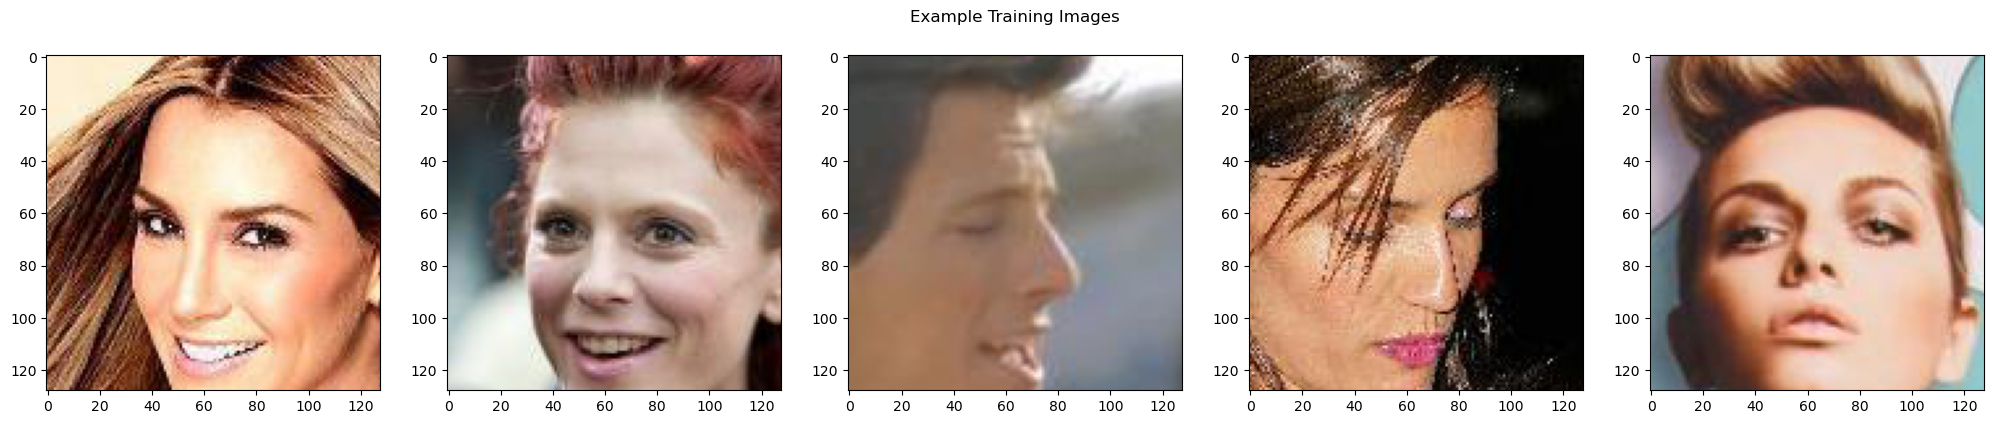

#Images in training set: 162079 
#Images in validation set: 40520


In [2]:
#Depending on your machine, memory may be a concern. Therefore, we will load images as they are needed.
#Alternatively, you can load all images into memory at once which will speed up training but may cause memory issues.
#Note: we do an 80/20 split for training and validation.

#os.makedirs('celeba_dataset', exist_ok=True)
assert os.path.exists('../datasets/celeba_dataset'), 'Please download the CelebA dataset and place it in the celeba_dataset folder'

class image_dataset(Dataset):
    def __init__(self, root_dir, transforms=None, train=True):
        self.root_dir = root_dir
        self.transforms = transforms
        self.file_list = sorted(os.listdir(root_dir))
        if train:
            self.file_list = self.file_list[:int(0.8*len(self.file_list))]
        else:
            self.file_list = self.file_list[int(0.8*len(self.file_list)):]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transforms:
            image = self.transforms(image)

        return image
    

transform_images = transforms.Compose([
                    transforms.CenterCrop((128, 128)),
                    transforms.ToTensor()
                ])

train_dataset = image_dataset(root_dir='../datasets/celeba_dataset/img_align_celeba', transforms=transform_images, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataset = image_dataset(root_dir='../datasets/celeba_dataset/img_align_celeba', transforms=transform_images, train=False)
val_dataloader = DataLoader(val_dataset, batch_size=256)

plt.figure(figsize=(25, 5))
plt.title('Example Training Images')
plt.axis('off')
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_dataset[i].permute(1, 2, 0))
plt.show()

print(f"#Images in training set: {train_dataset.__len__()} \n#Images in validation set: {val_dataset.__len__()}")

Let's create a function for the reparameterization and the custom loss class to include them in our model

Note: We use log(variance) instead of just the variance which is just a trick to improve numerical stability during the backpropagation.

Since $\log(\sigma^2)=2\log(\sigma)$, we adapt it to the following: $\frac{1}{2}\log(\sigma^2)=\log(\sigma)$.

Thus, the standard deviation is: $\sigma=e^{\frac{1}{2}\log(\sigma^2)}$ and z is sampled as $z=\mu+e^{\frac{1}{2}\log(\sigma^2)}\epsilon$

In [3]:
def reparameterization(mu, logvar):
    epsilon = torch.randn(mu.size(0), logvar.size(1)).to(mu.device)
    z = mu + torch.exp(logvar/2.0) * epsilon 
    return z


class ELBO_loss(pl.LightningModule):
    """
    The ELBO loss function for VAEs contains two terms: the reconstruction loss and the KL divergence.
    """
    def __init__(self):
        super(ELBO_loss, self).__init__()

    def forward(self, x, mu, logvar, decoded, alpha: float=0.001, **kwargs):
        """
        
        Parameters
        ----------
        x : torch.Tensor
            The input image.
        mu : torch.Tensor
            The mean of the latent distribution.
        logvar : torch.Tensor
            The log variance of the latent distribution.
        decoded : torch.Tensor
            The reconstructed image.
        alpha : float
            The weight of the KL divergence term.
        """
        assert logvar.shape == mu.shape, "mu and logvar must have the same shape"
        #KL Divergence between the prior latent and the surrogate latent distribution
        KLD = (-0.5*torch.sum(1+logvar-mu.pow(2)-torch.exp(logvar), axis=1)).mean()
        KLD = KLD*alpha #weighting KL divergence loss

        #Reconstruction Loss
        RL = torch.nn.MSELoss(reduction="none", **kwargs)(x, decoded)
        RL = RL.view(mu.size(0), -1).sum(axis=1).mean()
        return KLD+RL, KLD, RL

Time to create the VAE model

In [4]:
class VAE(pl.LightningModule):

    def __init__(
            self,
            lr: float = 0.0001,
            loss: Type = ELBO_loss,
            **kwargs
            ):
        super().__init__()
        self.lr = lr
        if not isinstance(loss, type):
            raise TypeError("The 'loss' parameter must be a class.")
        self.loss = loss()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2), #out: 32x63x63
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2), #out: 64x30x30
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2), #out: 128x14x14
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=3), #output size is 256x4x4
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Flatten(),
        )

        self.mu = torch.nn.Linear(256*4*4, 256)
        self.logvar = torch.nn.Linear(256*4*4, 256)

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(256, 256*4*4),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Unflatten(1, (256, 4, 4)),
            torch.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2), #out: 128x10x10
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=3), #out: 64x31x31
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2), #out: 32x64x64
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1), #out: 3x128x128
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.mu(encoded)
        logvar = self.logvar(encoded)
        z = reparameterization(mu, logvar)
        decoded = self.decoder(z)
        return x, mu, logvar, decoded
    
    def training_step(self, batch, batch_idx):
        x, mu, logvar, decoded = self(batch)
        train_loss, train_KL, train_RL = self.loss(x, mu, logvar, decoded, alpha = 1.0)

        #Log training loss every 10 batches
        if batch_idx % 10 == 0:
            self.log('train_loss', train_loss, on_step=True, on_epoch=True, prog_bar=True)
            wandb.log({"train/loss": train_loss})
            wandb.log({"train/KL": train_KL})
            wandb.log({"train/RL": train_RL})

        return train_loss
    
    def validation_step(self, batch, batch_idx):
        x, mu, logvar, decoded = self(batch)
        val_loss, val_KL, val_RL = self.loss(x, mu, logvar, decoded, alpha = 1.0)

        #Log training loss every 10 batches
        if batch_idx % 10 == 0:
            self.log('val_loss', val_loss, on_step=False, on_epoch=True, prog_bar=True)
            wandb.log({"val/loss": val_loss})
            wandb.log({"val/KL": val_KL})
            wandb.log({"val/RL": val_RL})

        return val_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [5]:
torch.set_float32_matmul_precision('medium')
wandb.init(project="VAE", entity="thatsvenyouknow")
model = VAE()
trainer = pl.Trainer(max_epochs=80, accelerator="auto")
trainer.fit(model, train_dataloader, val_dataloader)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: thatsvenyouknow. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\s_gue\anaconda3\envs\ml_basics\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss    | ELBO_loss  | 0     
1 | encoder | Sequential | 691 K 
2 | mu      | Linear     | 1.0 M 
3 | logvar  | Linear     | 1.0 M 
4 | decoder | Sequential | 1.7 M 
-------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\s_gue\anaconda3\envs\ml_basics\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


c:\Users\s_gue\anaconda3\envs\ml_basics\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 79: 100%|██████████| 634/634 [04:00<00:00,  2.64it/s, v_num=122, train_loss_step=597.0, val_loss=551.0, train_loss_epoch=598.0]   

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 634/634 [04:00<00:00,  2.63it/s, v_num=122, train_loss_step=597.0, val_loss=551.0, train_loss_epoch=598.0]


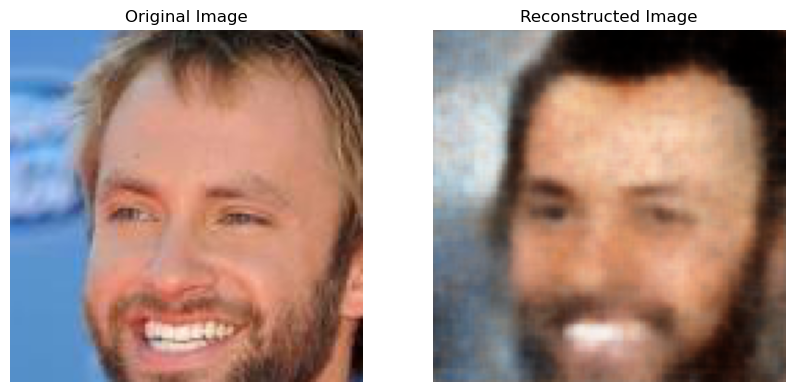

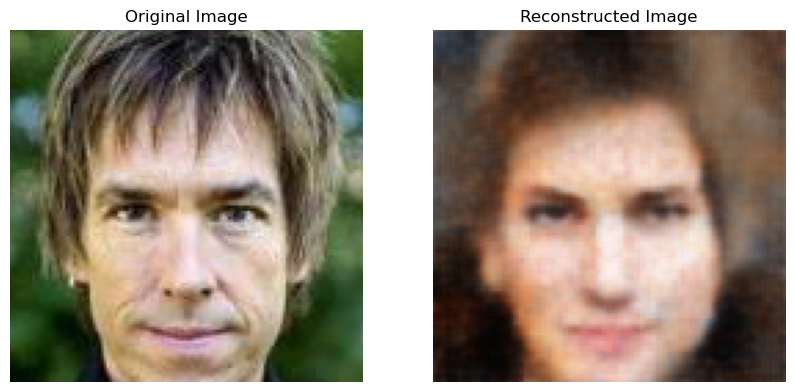

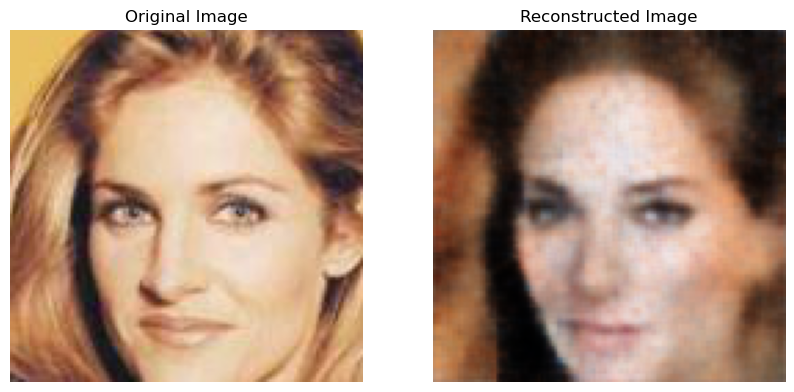

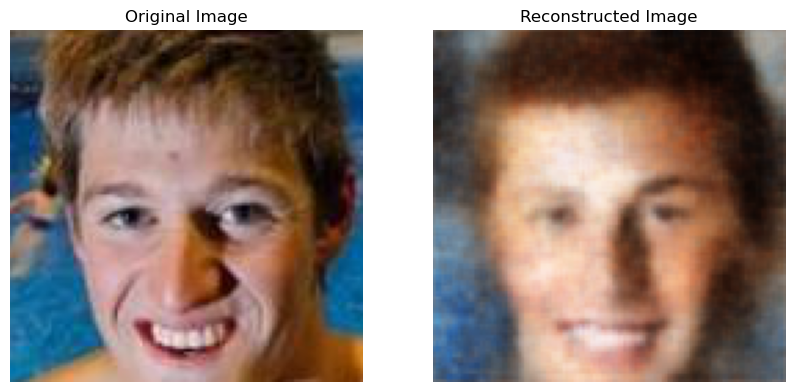

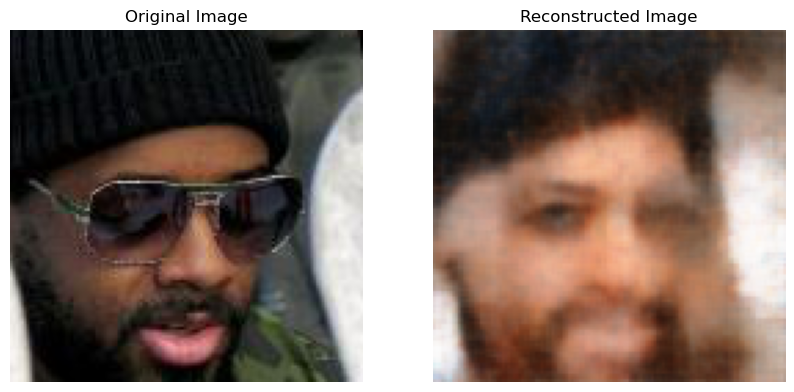

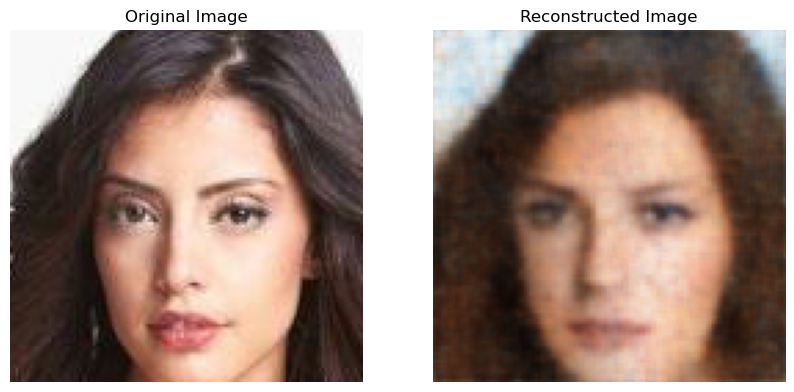

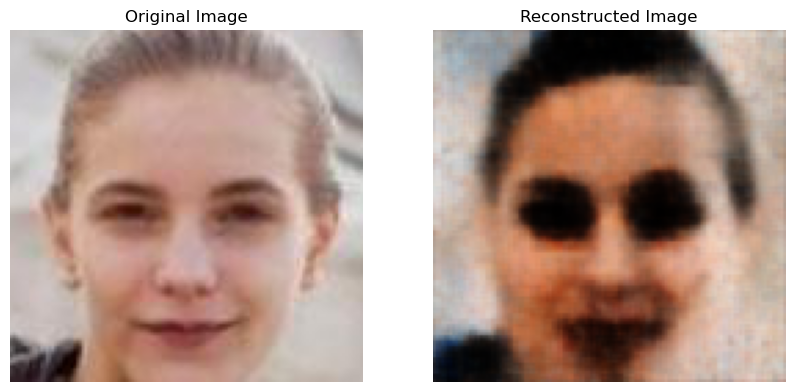

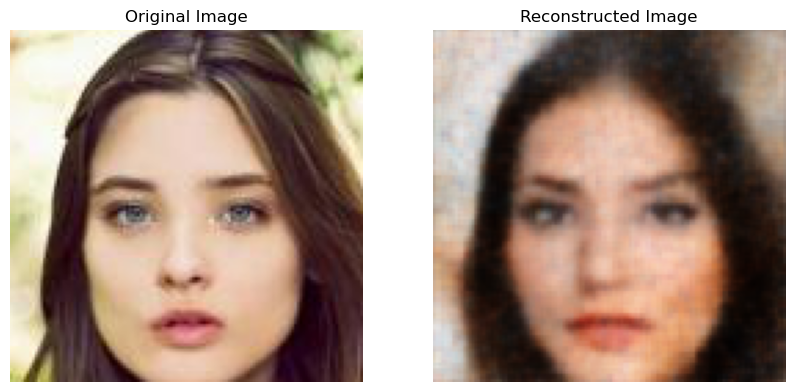

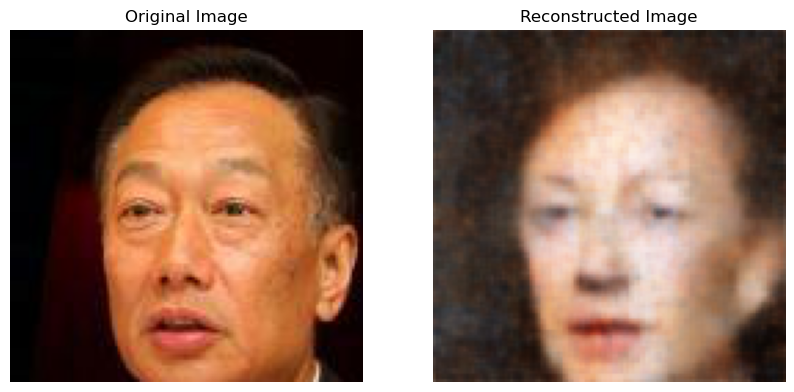

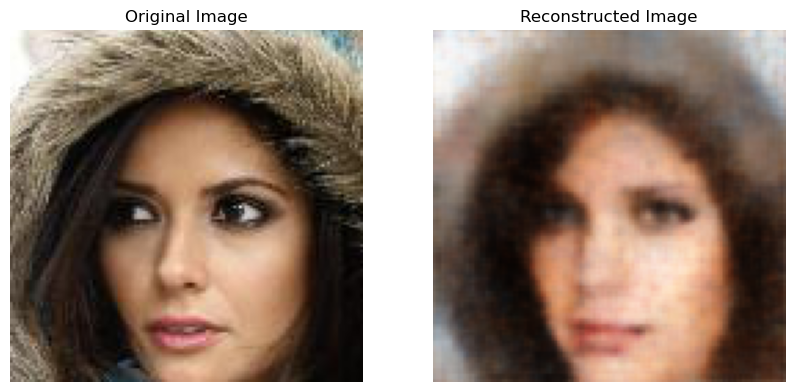

In [6]:
for i in range(10):
    a = model(val_dataset[i].unsqueeze(0))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.axis('off')
    plt.imshow(val_dataset[i].permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.title('Reconstructed Image')
    plt.axis('off')
    plt.imshow(a[-1].detach().squeeze().permute(1, 2, 0))
    plt.show()

Now, we can generate some new images

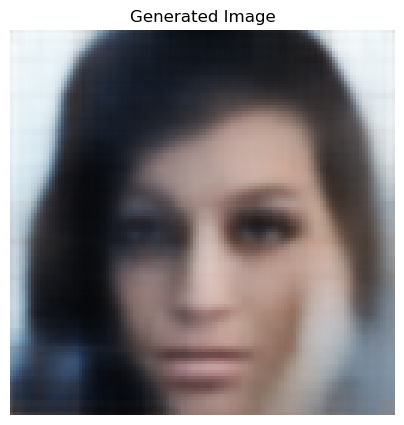

In [7]:
#model = VAE.load_from_checkpoint(checkpoint_path="./VAE.ckpt")
model.eval()
rand_sample = torch.randn(1, 256).to(model.device)
gen_image = model.decoder(rand_sample)

plt.figure(figsize=(5, 5))
plt.title('Generated Image')
plt.axis('off')
plt.imshow(gen_image.squeeze(0).cpu().detach().numpy().transpose(1, 2, 0))

### Further Reading

1. The paper that introduced VAEs 

- Kingma, D. P., & Welling, M. (2013). Auto-Encoding Variational Bayes. https://doi.org/10.48550/ARXIV.1312.6114

<br />

2. Very good video on Variational Inference and the ELBO method

- Machine Learning & Simulation. (2021, May 11). Variational Inference | Evidence Lower Bound (ELBO) | Intuition & Visualization [Video]. YouTube. https://www.youtube.com/watch?v=HxQ94L8n0vU

<br />

3. VAEs for Image Generation

- Pu, Y., Gan, Z., Henao, R., Yuan, X., Li, C., Stevens, A., & Carin, L. (2016). Variational Autoencoder for Deep Learning of Images, Labels and Captions. Neural Information Processing Systems.